# Übung 9 - Vanessa Schreck & Lisa Mattrisch

In [1]:
import pandas as pd
import numpy as np
import pdb
from collections import Counter
import itertools
from sklearn import metrics
from scipy.linalg import sqrtm
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

In [5]:
max(np.array([0,0],np.array([-1,2]))

SyntaxError: unexpected EOF while parsing (<ipython-input-5-5f5c057ea80d>, line 1)

In [19]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

def covariance_matrix(X, mu):
    num_samples, _ = X.shape
    X_normalized = X - mu
    return X_normalized.T.dot(X_normalized) / num_samples 

def normalize(data):
    mu = np.mean(data, axis = 0)
    cov = covariance_matrix(data, mu)
    while np.linalg.cond(cov) > 10**(14):
        cov = cov + 0.001*np.eye(len(cov))
        print('singular')
    return sqrtm(np.linalg.inv(cov)).dot((data - mu).T).T

In [3]:
#read data from file
train = pd.read_csv('C:/Users/LMatt/OneDrive/Dokumente/Mathe/Mustererkennung_Rojas/U1/train/data', 
                    delim_whitespace = True, header = None)
train_labels = np.array(train[:][0])
train_images = np.array(train)[:,1:]
train_images_normalized = normalize(train_images)

test = pd.read_csv('C:/Users/LMatt/OneDrive/Dokumente/Mathe/Mustererkennung_Rojas/U1/test/data', 
                   delim_whitespace = True, header = None)
test_labels = np.array(test[:][0])
test_images = np.array(test)[:,1:]
test_images_normalized = normalize(test_images)

In [4]:
class neural_network:
    def __init__(self, no_hiddenlayers, no_neurons, stepsize = 0.1, max_iter = 10, plot = False):
        self.no_hiddenlayers = no_hiddenlayers
        self.no_neurons = no_neurons
        # Gewichte zufällig aus [-1/sqrt(d), 1/sqrt(d)] initialisieren,
        # wobei d die Anzahl der Zeilen der jeweiligen Gewichtsmatrix ist:
        d = self.no_neurons[i] + 1
        self.weights = [2./np.sqrt(d)*(np.random.rand(d, self.no_neurons[i+1]) - 0.5) 
                        for i in range(self.no_hiddenlayers + 1)]
        self.stepsize = stepsize
        self.max_iter = max_iter
        self.digits = list(np.eye(10))
        self.plot = plot 
        
    def feedforward(self, x):
        ### Implemetierung des feedforward-Schrittes sowohl für das Lernverfahren 
        #   als auch die Prädiktion der Labels neuer Datenpunkte
        x = np.reshape(x, (len(x), len(x[0])))
        output_list = []
        for i in range(self.no_hiddenlayers + 1):
            x = np.concatenate((x, np.ones((len(x),1))), axis = 1)
            output_list.append(x)
            x = sigmoid(np.dot(x, self.weights[i]))
        x = np.concatenate((x, np.ones((len(x),1))), axis = 1)
        output_list.append(x)
        return output_list 
    
    def get_error_derivative(self, label, output_list):
        ### Erstellung der Ableitung der Fehlerfunktion nach einem feedforward-Schritt
        out = np.ndarray.flatten(output_list[-1][0,:-1])
        labelvector = np.zeros(10)
        labelvector[label] += 1  # Das Label 'i' wird als i-ter Einheitsvektor kodiert:
        self.error_derivative = out - labelvector
        
    def assemble_derivatives(self, output_list):
        ### Vorbereitung der Backpropagation: Ableitungen abspeichern
        derivative_list = []
        for i in range(self.no_hiddenlayers + 1):
            o = np.ndarray.flatten(output_list[i+1])[:-1]
            derivative_list.append(np.diag(o*(1-o)))
        self.derivative_list = derivative_list
    
    def backpropagation(self):
        ### Implementierung der Backpropagation
        delta_list = []
        weight_list = self.weights
        # Wir erweitern die Liste der Gewichtsmatrizen um eine Identitätsmatrix,
        # damit die Backpropagation als for-Schleife formuliert werden kann:
        weight_list.append(np.eye(len(self.error_derivative)))
        delta = self.error_derivative
        for i in range(self.no_hiddenlayers + 1)[::-1]:
            derivative = self.derivative_list[i]
            delta = derivative.dot(weight_list[i+1][:len(derivative),:]).dot(delta)
            delta_list.append(delta)
        self.delta_list = delta_list[::-1]
        
    def correction(self, output_list):
        ### Berechnung der Korrektur der Gewichtsmatrizen nach der Backpropagation
        delta_weights = []
        for i in range(self.no_hiddenlayers + 1):
            delta = np.reshape(self.delta_list[i], (len(self.delta_list[i]), 1))
            delta_weights.append(-self.stepsize*(delta.dot(output_list[i]).T))
        self.delta_weights = delta_weights
    
    def online_propagation(self):
        self.weights = [self.weights[i] + self.delta_weights[i] for i in range(self.no_hiddenlayers + 1)]
            
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        counter = 0
        accuracies = []
        # Pocket für die besten Gewichte:
        pocket_accuracy = 0
        while counter < self.max_iter:
            # Trainingspunkt zufällig wählen:
            idx = np.random.randint(len(self.data))
            train_point = self.data[idx]
            label = self.labels[idx]
            ### Führe Feedforward, Backpropagation und Korrektur aus
            output_list = self.feedforward(train_point[np.newaxis, :])
            self.get_error_derivative(label, output_list)
            self.assemble_derivatives(output_list)
            self.backpropagation()
            self.correction(output_list)
            self.online_propagation()
            predictions = self.predict(test_images)
            acc = self.accuracy(predictions, test_labels)
            accuracies.append(acc)
            if acc > pocket_accuracy:
                pocket_accuracy = acc
                pocket_weights = self.weights
            counter += 1
        self.weights = pocket_weights
        self.final_accuracy = pocket_accuracy
        # Plot der Entwicklung der Klassifikationsgenauigkeit
        if self.plot:
            plt.plot(accuracies)
            
    def predict(self, newdata):
        predictions = self.feedforward(newdata)[-1][:,:-1]
        predictions = np.argmax(predictions, axis = 1)
        return predictions
    
    def accuracy(self, predictions, labels):
        acc = sum(predictions == labels)/len(predictions)
        return acc

In [23]:
random.seed(0)
NN = neural_network(1, [256, 50, 10], .5, max_iter=3000, plot=True)

C:\Users\LMatt\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


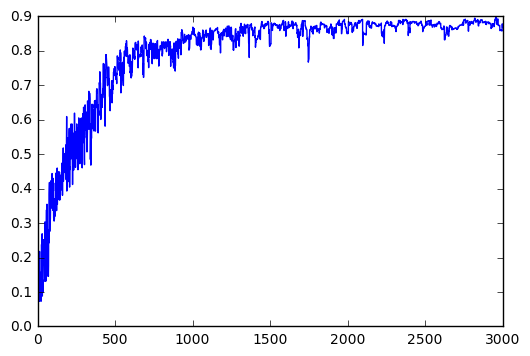

In [24]:
NN.fit(train_images, train_labels)

In [25]:
NN.final_accuracy

0.89885401096163431

Mit einer Hidden Layer mit $50$ Neuronen erreichen wir nach $3000$ Iterationen eine Klassifikationsgenauigkeit von $90 \%$. 

C:\Users\LMatt\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


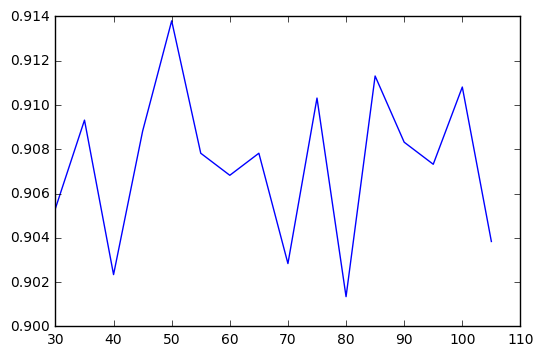

In [11]:
### für 1 hidden layer verschiedene Neuronenzahlen ausprobieren:
acc = []
for no_neurons in range(30, 110, 5):
    random.seed(0)
    NN = neural_network(1, [256, no_neurons, 10], .5, max_iter=5000)
    NN.fit(train_images, train_labels)
    acc.append(NN.final_accuracy)
plt.plot(range(30, 110, 5), acc)

Die beste Klassifikationsgauigkeit mit einer Hidden Layer erreichen wir nach wie vor mit $50$ Neuronen. Mit einer verlängerten Lernphase ($5000$ Iterationen) verbessert sich die Klassifikationsgauigkeit auf $91.4 \%$

In [21]:
### für 2 hidden layers verschieden Neuronenzahlen ausprobieren
x = range(30, 80, 10)
acc = np.zeros((len(x),len(x)))
for i,no_neurons1 in enumerate(x):
    for j,no_neurons2 in enumerate(x):
        random.seed(0)
        NN = neural_network(2, [256, no_neurons1, no_neurons2, 10], .5, max_iter=2000)
        NN.fit(train_images, train_labels)
        acc[i,j] = NN.final_accuracy

C:\Users\LMatt\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


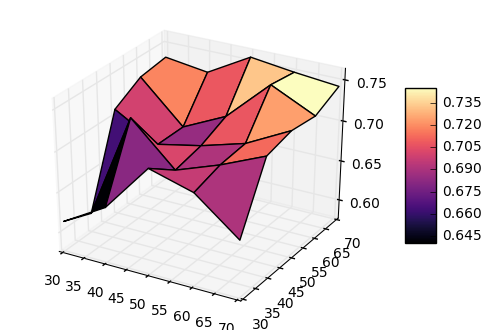

In [22]:
X,Y = np.meshgrid(x,x)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, acc, cmap=cm.magma, linewidth=1, cstride=1, rstride=1)
fig.colorbar(surf, shrink=0.5, aspect=5)

Mit $2$ Hidden Layers konnten wir keine besseren Ergebnisse erzielen, also versuchen wir es nochmal mit einer Hidden Layer und längerer Lernphase:

C:\Users\LMatt\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


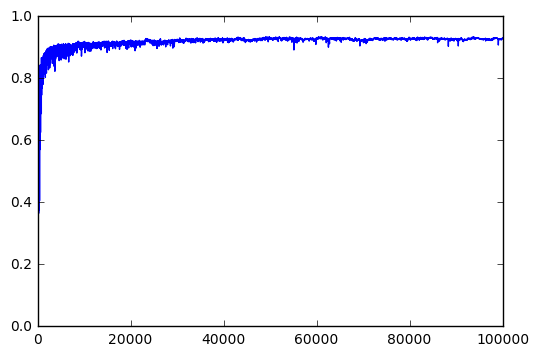

In [30]:
random.seed(0)
NN = neural_network(1, [256, 50, 10], .5, max_iter=100000, plot=True)
NN.fit(train_images, train_labels)

In [31]:
# 100.000 Iterationen
NN.final_accuracy

0.93472845042351771